In [1]:
import pandas as pd

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
df = pd.read_csv('../Data/loreal_stock_price.csv', parse_dates=['Date'], index_col='Date')
# Assuming 'df' is your DataFrame and 'Close' is the column with daily closing prices
# Convert to numpy array for scaling and reshape
data = df[['Close']].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print ("scaled_data shape: ", scaled_data.shape)

scaled_data shape:  (1285, 1)


In [4]:


# Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
        
    return np.array(X), np.array(y)

# Define sequence length and prepare the dataset
sequence_length = 60  # This means each input sequence will be 60 days of past data
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit LSTM model (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Undo scaling

# Inverse transform the actual test values as well
y_test_scaled = scaler.inverse_transform([y_test])
y_test_scaled = y_test_scaled[0]



Epoch 1/5
31/31 [==============================] - 9s 104ms/step - loss: 0.0301 - val_loss: 0.0051
Epoch 2/5
31/31 [==============================] - 2s 62ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 3/5
31/31 [==============================] - 2s 63ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/5
31/31 [==============================] - 2s 65ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 5/5
8/8 [==============================] - 1s 18ms/step


In [5]:
index  = pd.date_range(start=df.index[-1], periods=61, freq='B')
index = index[1:]
index = df.index.append(index)
index = index[sequence_length:]

In [6]:
def make_prediction(data, scaler, model, sequence_length, index):

    for i in range (61):
        # Create sequences
        print ("data shape: ", data.shape)
        X, y = create_sequences(data, sequence_length)

        # Reshape the data
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Make a prediction
        prediction = model.predict(X)
        data = np.append(data, [prediction[-1]], axis=0)

        # Inverse transform the prediction
    prediction = scaler.inverse_transform(prediction)
    prediction = pd.Series(prediction.flatten(), index=index)
    return prediction

# Make a prediction for the next 30 days
future_prediction = make_prediction(scaled_data, scaler, model, sequence_length, index)

data shape:  (1285, 1)
39/39 [==============================] - 1s 17ms/step
data shape:  (1286, 1)
39/39 [==============================] - 1s 18ms/step
data shape:  (1287, 1)
39/39 [==============================] - 1s 17ms/step
data shape:  (1288, 1)
39/39 [==============================] - 1s 18ms/step
data shape:  (1289, 1)
39/39 [==============================] - 1s 17ms/step
data shape:  (1290, 1)
39/39 [==============================] - 1s 17ms/step
data shape:  (1291, 1)
39/39 [==============================] - 1s 20ms/step
data shape:  (1292, 1)
39/39 [==============================] - 1s 18ms/step
data shape:  (1293, 1)
39/39 [==============================] - 1s 18ms/step
data shape:  (1294, 1)
39/39 [==============================] - 1s 19ms/step
data shape:  (1295, 1)
39/39 [==============================] - 1s 17ms/step
data shape:  (1296, 1)
39/39 [==============================] - 1s 19ms/step
data shape:  (1297, 1)
39/39 [==============================] - 1s 18ms/step

In [7]:
future_prediction.to_csv('../Data/LSTM_future_prediction.csv')

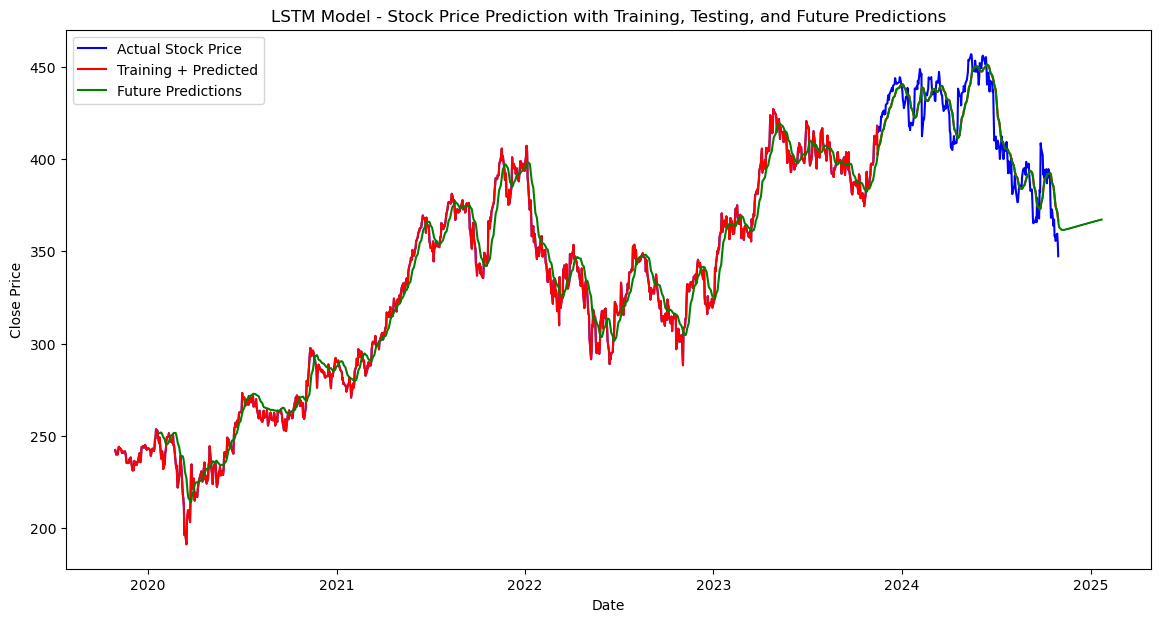

In [8]:
# Create a DataFrame to hold both training data and predictions
train_data = df['Close'][:train_size + sequence_length ]  # Adding sequence_length to align with X_train
predicted_data = pd.DataFrame(predictions, index=df['Close'].index[train_size + sequence_length :], columns=['Predicted'])

# Concatenate training data and predictions
combined_data = pd.concat([train_data, predicted_data['Predicted']], axis=0)
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Actual Stock Price', color='blue')
plt.plot(combined_data, label='Training + Predicted', color='red')
plt.plot(future_prediction, label='Future Predictions', color='green')
plt.title('LSTM Model - Stock Price Prediction with Training, Testing, and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [9]:
# Calculate the error metrics
mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
r_squared = r2_score(y_test_scaled, predictions)
print(f'R-squared: {r_squared:.2f}')
adj_r_squared = 1 - (1 - r_squared) * (len(y_test_scaled) - 1) / (len(y_test_scaled) - X_test.shape[1] - 1)
print(f'Adjusted R-squared: {adj_r_squared:.2f}')

Mean Squared Error: 126.21
Mean Absolute Error: 9.15
R-squared: 0.82
Adjusted R-squared: 0.76


In [10]:
def predict_future(data, days, scaler, model):
    # Scale the data
    scaled_data = scaler.transform(data)
    
    # Create sequences
    X = []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
    X = np.array(X)
    
    # Reshape data for LSTM model
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    # Make predictions
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    
    # Create future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date, periods=days + 1, freq='B')[1:]
    
    # Create a DataFrame of future dates and predictions
    predictions = pd.DataFrame(predictions, index=future_dates, columns=['Predicted'])
    
    return predictions